<a href="https://colab.research.google.com/github/heroza/Skin-Cancer-Diagnosis/blob/main/Skin_Cancer_Diagnosis_using_ISIC_2018_Dataset_DeepSMOTE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prepare the dataset. 
Currently, we use skin cancer ISIC dataset from Kaggle https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic

Tutorial for how to load Kaggle dataset can be found in https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Load Data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, confusion_matrix
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model, load_model

!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df_train = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv') 
df_val = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv') 
num_classes = 7
#df_train

In [3]:
#decode one hot label
df_train["Labels"] = (df_train.iloc[:, 1:]).idxmax(axis=1)
df_val["Labels"] = (df_val.iloc[:, 1:]).idxmax(axis=1)

#drop one-hot column
df_train = df_train.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])
df_val = df_val.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])

#make filepaths of the image
dir_train = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_Input/'
dir_val = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_Input/'
df_train['FilePaths'] = dir_train + df_train['image'] + '.jpg'
df_val['FilePaths'] = dir_val + df_val['image'] + '.jpg'

Label Distribution

[Text(0, 0, 'DF'),
 Text(0, 0, 'VASC'),
 Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV')]

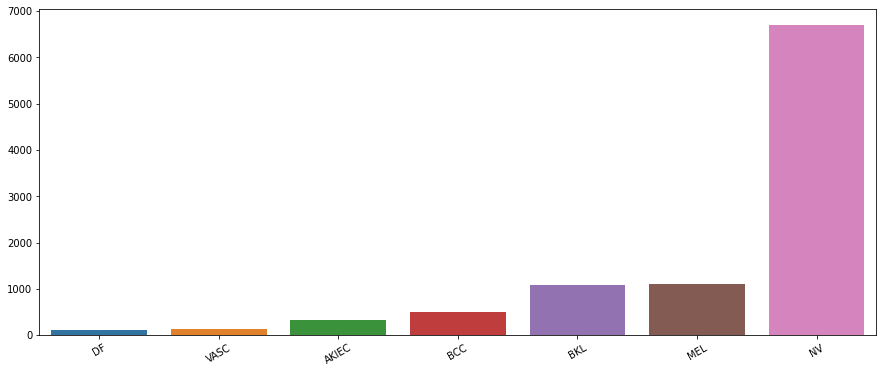

In [4]:
# ordered count of rows per unique label
labels_count = df_train['Labels'].value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

In [6]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(row['Labels'] == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df_train['Labels'].unique())
#for label in labels:
#    plot_images_per_label(df_train, label, 3, (12,9))

Drop duplicate images

In [7]:
#df_group = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_LesionGroupings.csv') 
#df_train = df_train.set_index('image').join(df_group.set_index('image'))
#df_train = df_train.drop_duplicates(subset=['lesion_id'])


Manual undersampling majority class

In [6]:
df_train = df_train.drop(df_train[df_train['Labels'] == 'NV'].sample(frac=.7).index)

Prepare X,y

In [7]:
# input image size
IMAGE_W = 224
IMAGE_H = 224
IMG_SIZE = (IMAGE_W,IMAGE_H)

In [ ]:
#TIME CONSUMING OPERATION
#from tensorflow.keras.preprocessing.image import load_img, img_to_array
#X = []
#for img in df['FilePaths']:
    #img_arr = load_img(img, target_size=IMG_SIZE)
#    with load_img(img, target_size=IMG_SIZE) as img_arr:
#      X.append(img_to_array(img_arr))

#X = np.array(X)
df_train['image_px'] = df_train['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))
df_val['image_px'] = df_val['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

In [ ]:
X_train = np.asarray(df_train['image_px'].tolist())
X_val = np.asarray(df_val['image_px'].tolist())
print(np.array(X_train).shape)
print(np.array(X_val).shape)

In [ ]:
y_train = np.array(df_train['Labels'].values)

# summarize class distribution
from collections import Counter
counter = Counter(y_train)
print(counter)
print(y_train.shape)

In [ ]:
y_val = np.array(df_val['Labels'].values)
print(Counter(y_val))
print(y_val.shape)

In [ ]:
#label encoding
label_encoder = preprocessing.LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.fit_transform(y_val)
y_train

#SMOTE Oversampling

In [ ]:
def SMOTE_Data(X, y):
  sm = SMOTE(random_state=42, k_neighbors=5)
  X_resampled, y_resampled = sm.fit_resample(X.reshape((-1, IMAGE_W * IMAGE_H * 3)), y)
  X_resampled.reshape(-1, IMAGE_W, IMAGE_H, 3)
  return X_resampled, y_resampled

In [ ]:
X_train, y_train = SMOTE_Data(X_train, y_train) #beware of the actual parameter
print(X_train.shape)
print(y_train.shape)

(14077, 150528)
(14077,)


In [ ]:
counter = Counter(y_train)
print(counter)

Counter({5: 2011, 4: 2011, 2: 2011, 3: 2011, 0: 2011, 1: 2011, 6: 2011})


In [ ]:
X_train = X_train.reshape(-1, IMAGE_W, IMAGE_H, 3)
print('X_train shape: ',X_train.shape)

X_train shape:  (14077, 224, 224, 3)


#DeepSMOTE Oversampling

In [ ]:
#Normalization
#X_train_mean = np.mean(X_train)
#X_train_std = np.std(X_train)

#X_train = (X_train - X_train_mean)/X_train_std
#X_val = (X_val - X_train_mean)/X_train_std

In [ ]:
#optional
#X=X_train
#y=y_train

from numpy import moveaxis
X_train = moveaxis(X_train, 3, 1)
X_train = X_train.astype('float32') / 255.
#dec_x = X_train 
#dec_y = y

#create counter for encoder
counter = sorted(counter.items())
counter = [value for _, value in counter]

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from sklearn.neighbors import NearestNeighbors
import time
import os

print(torch.version.cuda) #10.1

args = {}
args['dim_h'] = 64         # factor controlling size of hidden layers
args['n_channel'] = 3#1    # number of channels in the input data 

args['n_z'] = 600 #300     # number of dimensions in latent space. 

args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = 300       # how many epochs to run for
args['batch_size'] = 6   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = False       # train networks if True, else load networks from

args['patience'] = 20

## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),# 112
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False), # 56
            nn.BatchNorm2d(self.dim_h * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),# 28
            nn.BatchNorm2d(self.dim_h * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),#14
            nn.BatchNorm2d(self.dim_h * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 8, self.dim_h * 16, 4, 2, 1, bias=False),#7
            nn.BatchNorm2d(self.dim_h * 16),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 16, self.dim_h * 32, 7, 1, 0, bias=False),#1
            nn.BatchNorm2d(self.dim_h * 32), # 40 X 8 = 320
            nn.LeakyReLU(0.2, inplace=True) )#,
        self.fc = nn.Linear(self.dim_h * (2 ** 5), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        
        x = x.squeeze()
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 2**5 * 7 * 7),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        # H_out ​= (H_in​−1)*stride[0] − 2×padding[0] + dilation[0]×(kernel_size[0]−1) + output_padding[0] + 1
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 32, self.dim_h * 16, 4, 2, 1), # 14
            nn.BatchNorm2d(self.dim_h * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 16, self.dim_h * 8, 4, 2, 1), # 28
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4, 2, 1), #56
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4, 2, 1), #112
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 3, 4, stride=2, padding=1),# 224
            #nn.Sigmoid())
            nn.Tanh())

    def forward(self, x):
        #print('dec')
        #print('input ',x.size())
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 2**5, 7, 7)
        x = self.deconv(x)
        return x

##############################################################################
"""set models, loss functions"""
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False


##############################################################################
"""functions to create SMOTE images"""

def biased_get_class(X, y, c):
    
    xbeg = X[y == c]
    ybeg = y[y == c]
    
    return xbeg, ybeg
    #return xclass, yclass


def G_SM(X, y,n_to_sample,cl):

    # determining the number of samples to generate
    #n_to_sample = 10 

    # fitting the model
    n_neigh = 5
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

#xsamp, ysamp = SM(xclass,yclass)

In [ ]:
#Begin the training
batch_size = args['batch_size']
patience = args['patience']
encoder = Encoder(args)
decoder = Decoder(args)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
decoder = decoder.to(device)
encoder = encoder.to(device)

train_on_gpu = torch.cuda.is_available()

#decoder loss function
criterion = nn.MSELoss()
criterion = criterion.to(device)

num_workers = 0

#torch.Tensor returns float so if want long then use torch.tensor
tensor_x = torch.Tensor(X_train)
tensor_y = torch.tensor(y_train,dtype=torch.long)
mnist_bal = TensorDataset(tensor_x,tensor_y) 
train_loader = torch.utils.data.DataLoader(mnist_bal, 
    batch_size=batch_size,shuffle=True,num_workers=num_workers)

best_loss = np.inf

t0 = time.time()
if args['train']:
    enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
    dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

    for epoch in range(args['epochs']):
        train_loss = 0.0
        tmse_loss = 0.0
        tdiscr_loss = 0.0
        # train for one epoch -- set nets to train mode
        encoder.train()
        decoder.train()
    
        for images,labs in train_loader:
        
            # zero gradients for each batch
            encoder.zero_grad()
            decoder.zero_grad()
            images, labs = images.to(device), labs.to(device)
            labsn = labs.detach().cpu().numpy()
#            print('images shape', images.shape)
            # run images
            z_hat = encoder(images)
#            print('images shape after encoding', z_hat.shape)
        
            x_hat = decoder(z_hat) #decoder outputs tanh
#            print('images shape after decoding', x_hat.shape)
            mse = criterion(x_hat,images)
                    
            resx = []
            resy = []
        
            tc = np.random.choice(num_classes,1)
            #tc = 9
            xbeg = X_train[y_train == tc]
            ybeg = y_train[y_train == tc] 
            xlen = len(xbeg)
            nsamp = min(xlen, 100)
            ind = np.random.choice(list(range(len(xbeg))),nsamp,replace=False)
            xclass = xbeg[ind]
            yclass = ybeg[ind]
        
            xclen = len(xclass)
            xcminus = np.arange(1,xclen)
            
            xcplus = np.append(xcminus,0)
            xcnew = (xclass[[xcplus],:])
            xcnew = xcnew.reshape(xcnew.shape[1],xcnew.shape[2],xcnew.shape[3],xcnew.shape[4])
        
            xcnew = torch.Tensor(xcnew)
            xcnew = xcnew.to(device)
        
            #encode xclass to feature space
            xclass = torch.Tensor(xclass)
            xclass = xclass.to(device)
            xclass = encoder(xclass)
        
            xclass = xclass.detach().cpu().numpy()
        
            xc_enc = (xclass[[xcplus],:])
            xc_enc = np.squeeze(xc_enc)
        
            xc_enc = torch.Tensor(xc_enc)
            xc_enc = xc_enc.to(device)
            
            ximg = decoder(xc_enc)
            
            mse2 = criterion(ximg,xcnew)
        
            comb_loss = mse2 + mse
            comb_loss.backward()
        
            enc_optim.step()
            dec_optim.step()
        
            train_loss += comb_loss.item()*images.size(0)
            tmse_loss += mse.item()*images.size(0)
            tdiscr_loss += mse2.item()*images.size(0)

        train_loss = train_loss/len(train_loader)
        tmse_loss = tmse_loss/len(train_loader)
        tdiscr_loss = tdiscr_loss/len(train_loader)
        print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
                train_loss,tmse_loss,tdiscr_loss))
        
    
    
        #store the best encoder and decoder models
        #here, /crs5 is a reference to 5 way cross validation, but is not
        #necessary for illustration purposes
        if train_loss < best_loss:
            print('Saving..')
            patience = args['patience']
            path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/bst_enc.pth'
            path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/bst_dec.pth'
          
            torch.save(encoder.state_dict(), path_enc)
            torch.save(decoder.state_dict(), path_dec)
    
            best_loss = train_loss
        else:
            patience = patience - 1

        if patience == 0:
            print('Out of patience. \n')
            break
    
    
    #in addition, store the final model (may not be the best) for
    #informational purposes
    path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/f_enc.pth'
    path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/f_dec.pth'
    print(path_enc)
    print(path_dec)
    torch.save(encoder.state_dict(), path_enc)
    torch.save(decoder.state_dict(), path_dec)

cuda
Epoch: 0 	Train Loss: 0.775552 	mse loss: 0.407762 	mse2 loss: 0.367790
Saving..
Epoch: 1 	Train Loss: 0.211056 	mse loss: 0.111666 	mse2 loss: 0.099390
Saving..
Epoch: 2 	Train Loss: 0.153950 	mse loss: 0.078980 	mse2 loss: 0.074970
Saving..
Epoch: 3 	Train Loss: 0.137521 	mse loss: 0.070455 	mse2 loss: 0.067066
Saving..
Epoch: 4 	Train Loss: 0.123724 	mse loss: 0.064348 	mse2 loss: 0.059376
Saving..
Epoch: 5 	Train Loss: 0.114418 	mse loss: 0.059063 	mse2 loss: 0.055354
Saving..
Epoch: 6 	Train Loss: 0.110404 	mse loss: 0.057641 	mse2 loss: 0.052763
Saving..
Epoch: 7 	Train Loss: 0.099953 	mse loss: 0.053611 	mse2 loss: 0.046341
Saving..
Epoch: 8 	Train Loss: 0.094897 	mse loss: 0.051286 	mse2 loss: 0.043611
Saving..
Epoch: 9 	Train Loss: 0.090954 	mse loss: 0.050273 	mse2 loss: 0.040682
Saving..
Epoch: 10 	Train Loss: 0.087089 	mse loss: 0.048824 	mse2 loss: 0.038265
Saving..
Epoch: 11 	Train Loss: 0.082592 	mse loss: 0.046604 	mse2 loss: 0.035989
Saving..
Epoch: 12 	Train Loss

In [ ]:
#Generate artificial images
import torch
np.printoptions(precision=5,suppress=True)

#path on the computer where the models are stored
modpth = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/'

encf = []
decf = []
for p in range(1):
    enc = modpth + '/bst_enc.pth'
    dec = modpth + '/bst_dec.pth'
    encf.append(enc)
    decf.append(dec)

for m in range(1):
    print('train imgs shape ',X_train.shape) #(45000,3,32,32)
    print('decy ',y_train.shape)
    
    #generate some images 
    train_on_gpu = torch.cuda.is_available()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    path_enc = encf[m]
    path_dec = decf[m]

    encoder = Encoder(args)
    encoder.load_state_dict(torch.load(path_enc), strict=False)
    encoder = encoder.to(device)

    decoder = Decoder(args)
    decoder.load_state_dict(torch.load(path_dec), strict=False)
    decoder = decoder.to(device)

    encoder.eval()
    decoder.eval()

    resx = []
    resy = []

    for i in [0,1,2,3,4,6]: #skip class 5 since it's max class
        torch.cuda.empty_cache()

        xclass, yclass = biased_get_class(X_train, y_train, i)
#        print(xclass.shape) #(500, 3, 32, 32)
#        print(yclass[0]) #(500,)
            
        #encode xclass to feature space
        xclass = torch.Tensor(xclass)
        xclass = xclass.to(device)
        xclass = encoder(xclass)
            
        xclass = xclass.detach().cpu().numpy()
        n = np.max(counter) - counter[i]
        xsamp, ysamp = G_SM(xclass,yclass,n,i)
#        print(xsamp.shape) #(4500, 600)
#        print(len(ysamp)) #4500
        ysamp = np.array(ysamp)
    
        """to generate samples for resnet"""   
        xsamp = torch.Tensor(xsamp)
        xsamp = xsamp.to(device)
        ximg = decoder(xsamp)

        ximn = ximg.detach().cpu().numpy()
#        print(ximn.shape) 
        resx.append(ximn)
        resy.append(ysamp)
    
    resx1 = np.vstack(resx)
    resy1 = np.hstack(resy)
#    print(resx1.shape) #(34720, 3, 32, 32)

    resx1 = resx1.reshape(resx1.shape[0],-1)
#    print(resx1.shape) #(34720, 3072)
    
    dec_x1 = X_train.reshape(X_train.shape[0],-1)
#    print('decx1 ',dec_x1.shape)
    combx = np.vstack((resx1,dec_x1))
    comby = np.hstack((resy1,y_train))

    print(combx.shape) #(45000, 3, 32, 32)
    print(comby.shape) #(45000,)
#    print()

In [ ]:
X_train = combx.reshape(-1, 3, IMAGE_W, IMAGE_H)
X_train = moveaxis(X_train, 1, 3)
print('X_train shape: ',X_train.shape)
y_train = comby
print(Counter(comby))

In [ ]:
X_train = X_train * 255
X_train = X_train.astype(int)

In [ ]:
#de-standardization
#X_train = (X_train * X_train_std + X_train_mean).astype(int)
#X_val = (X_val * X_train_std + X_train_mean).astype(int)

#Data Transformation

In [ ]:
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
print('y_train shape: ',y_train.shape)

In [ ]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = num_classes)
y_val = to_categorical(y_val, num_classes = num_classes)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

#Split dataset to train and val

In [ ]:
# stratified train and rem (20%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.02, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Remaining Data: ', X_val.shape)

Train Data:  (9814, 32, 32, 3)
Remaining Data:  (201, 32, 32, 3)


In [ ]:
# stratified val and test (50%) 
from sklearn.model_selection import train_test_split
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=1)

print('Test Data: ', X_test.shape)
print('Val Data: ', X_val.shape)

Test Data:  (416, 32, 32, 3)
Val Data:  (416, 32, 32, 3)


In [ ]:
#optional
# stratified train and test (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Test Data: ', X_test.shape)

Train Data:  (2015, 32, 32, 3)
Test Data:  (224, 32, 32, 3)


In [ ]:
#optional
# stratified train and val (10%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

print('Train Data: ', X_train.shape)
print('Val Data: ', X_val.shape)

Train Data:  (3369, 32, 32, 3)
Val Data:  (375, 32, 32, 3)


Create and compile the model

In [ ]:
print(X_train)

In [ ]:
#Data Augmentation
dataaugment = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(X_train)

# Classification
Model from https://github.com/AnasBrital98/CNN-From-Scratch/tree/master/Inception-V3

In [ ]:
EPOCHS = 1000
BATCH_SIZE = 32
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#USe TF.data
training_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validation_data = tf.data.Dataset.from_tensor_slices((X_val, y_val))

autotune = tf.data.AUTOTUNE
train_data_batches = training_data.shuffle(buffer_size=40000).batch(32).prefetch(buffer_size=autotune)
valid_data_batches = validation_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=autotune)

#Data augmentation
rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

def balanced_acc(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    import numpy as np
    from keras import backend as K

    tensor1 = tf.math.argmax(y_true, axis=1)
    tensor2 = tf.math.argmax(y_pred, axis=1)

    cm = tf.math.confusion_matrix(tensor1, tensor2)
    
    diag = tf.linalg.tensor_diag_part (cm)
    tpfn = tf.cast(K.sum(cm, axis = 1), tf.float32) + K.epsilon()
    recall = tf.divide(tf.cast(diag, tf.float32),tpfn)
    balanced_acc = K.mean(recall)
    return balanced_acc

#Callbacks
best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model_SMOTE.h5'
last_model_fpath = '/content/drive/MyDrive/PHD/Model/last_model_SMOTE.h5'
mc = ModelCheckpoint(best_model_fpath, monitor='val_balanced_acc', mode='max', verbose=1, save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=30,monitor='val_balanced_acc')


In [ ]:
#Training
input_shape = X_train.shape[1:]
input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
x = data_augmentation(input_tensor)
#x = rescale_layer(x)

base_model = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
x = base_model(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
#hst = model.fit(dataaugment.flow(X_train,y_train, batch_size=BATCH_SIZE),
hst = model.fit(train_data_batches,
                    epochs = EPOCHS, validation_data = valid_data_batches,      
                    #steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


In [ ]:
# summarize history for accuracy
plt.plot(hst.history['balanced_acc'])
plt.plot(hst.history['val_balanced_acc'])
plt.title('Model balanced accuracy')
plt.ylabel('Balanced Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Fine Tune

In [ ]:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

optimizer_SGD = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer = optimizer_SGD , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
hst2 = model.fit(train_data_batches,
                    epochs = EPOCHS, validation_data = valid_data_batches,
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


In [ ]:
#save last model

#model.save(last_model_fpath)

In [ ]:
#last_model = load_model(last_model_fpath)
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

In [ ]:
#best_model = load_model(best_model_fpath)
#y_train_pred = best_model.predict(X_train)
#y_val_pred = best_model.predict(X_val)

print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

In [ ]:
# summarize history for accuracy
plt.plot(hst2.history['balanced_acc'])
plt.plot(hst2.history['val_balanced_acc'])
plt.title('model balance_acc after tunning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Testing
Result from ISIC Live
last_model: 0.506
best_model: 0.478

In [ ]:
dir_test = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Test_Input/'
filepaths = sorted( filter( lambda x: (os.path.isfile(os.path.join(dir_test, x))) and (x.endswith('.jpg')),
                        os.listdir(dir_test) ) )

In [ ]:
df_test = pd.DataFrame(filepaths, columns =['image'])
df_test['FilePaths'] = dir_test + df_test['image']
#df_test

In [ ]:
df_test['image_px'] = df_test['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

In [ ]:
X_test = np.asarray(df_test['image_px'].tolist())
print(np.array(X_test).shape)

Calculate y_pred from training and testing for analysis

In [ ]:
# predicted labels
Y_pred2 = model.predict(X_test)
print("Y_pred2", Y_pred2.shape)
# rounded labels
y_pred2 = np.argmax(Y_pred2, axis=1)
print("y_pred2", y_pred2.size)

In [ ]:
df_pred = pd.DataFrame(Y_pred2, columns = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
df_pred['image'] = df_test['FilePaths'].map(lambda x: x.replace(dir_test, '').replace('.jpg', ''))
df_pred = df_pred[['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']]

In [ ]:
df_pred.set_index("image", inplace = True)
df_pred.to_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/response_DeepSMOTEOversampling_last.csv')

#Confusion Metric on Validation Set

In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1))

print(cf_matrix)

In [ ]:
ax = sns.heatmap(cf_matrix / cf_matrix.sum(axis=1, keepdims=True), annot=True, 
            cmap='Blues')

ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
ax.yaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

plt.rcParams["figure.figsize"] = (15,3)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

In [ ]:
# ordered count of rows per unique label
labels_count = df_val['Labels'].value_counts().sort_index()

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)